# 独自データの分類
# testデータセットによる性能評価とtrainerの活用


In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.dataset import concat_examples
import inspect
from jupyterthemes import jtplot
jtplot.style()
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)



## データ用意

In [2]:
file = open("thick.txt", mode='r')
lines = file.readlines()

file.close()

train_pos = []
t_label = []

arr_whole_data = [];
arr_whole_target = [];
for line in lines:
    arr = line.strip().split(",")
    arr_whole_data.append([int(arr[0]), int(arr[1])])
    arr_whole_target.append(int(arr[2]))

arr_whole_data[0:5]
arr_whole_target[0:5]

whole_data = np.array(arr_whole_data, np.float32)/np.array([640,480], np.float32)
whole_target = np.array(arr_whole_target, np.int32)

whole_data[0:5]
whole_target[0:5]


test_len = int(len(whole_data)/4)

#データセットを作る
dataset = datasets.TupleDataset(whole_data, whole_target)

#split_dataset_randomで、ランダムにデータセットを分けられる　学習データとテストデータに分ける
test, train = datasets.split_dataset_random(dataset, test_len, 1234)

#学習データ数
len(train)

#イテレータの作成
batch_size = 10
train_iter = iterators.SerialIterator(train, batch_size=batch_size)
test_iter = iterators.SerialIterator(test, batch_size=batch_size, repeat=False, shuffle=False)

[[618, 114], [596, 108], [483, 109], [431, 111], [406, 118]]

[0, 0, 0, 0, 0]

array([[ 0.96562499,  0.2375    ],
       [ 0.93124998,  0.22499999],
       [ 0.75468749,  0.22708334],
       [ 0.67343748,  0.23125   ],
       [ 0.63437498,  0.24583334]], dtype=float32)

array([0, 0, 0, 0, 0])

429

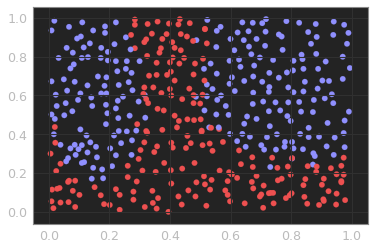

In [3]:
#学習用データの表示
#Tupleデータセットを可視化する…データセットから数値を抜き出してnp.arrayにもう一度戻す
def plotWholeData():
    X = np.array([[dt[0][0] for dt in train],[dt[0][1] for dt in train]], np.float32).T
    y = np.array([dt[1] for dt in train], np.int32)
    cm = generate_cmap(['#EE5050', '#9090FF'])
    plt.scatter(X[:,0], X[:,1], c=y, cmap = cm)

plotWholeData()

In [4]:
#モデルを用意

class SimpleModel(Chain):
    def __init__(self, n_out):
        super(SimpleModel, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 100)
            self.l2 = L.Linear(None, 100)
            self.l3 = L.Linear(None, n_out)
    
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

In [10]:
model = SimpleModel(2)
optimizer = optimizers.Adam()
optimizer.setup(model)

In [11]:
train_iter.reset()

学習データセットを1エポック回し終わるたびに、テストデータセットでの評価（loss, accuracy）を行う

学習データセットもlossとaccuracyの集計は行っておく

どちらも平均をとるため、各バッチごとに計算した値を配列へ保存、最後にnp.sumで合計し、データ数で割る

集計したlossとaccuracyはファイルへ書き込み

In [12]:
max_epoch = 500

log = open("trainLog.log", mode="w")
log.write("epoch,train/loss,train/accuracy,test/loss,test/accuracy\n")

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

while train_iter.epoch < max_epoch:
    example = train_iter.next()
    x, t = concat_examples(example)    
    y = model(x)
    loss = F.softmax_cross_entropy(y, t)
    model.cleargrads()
    loss.backward()
    optimizer.update()
    accuracy = F.accuracy(y, t)
    train_loss.append(loss.data)
    train_accuracy.append(accuracy.data)
    if train_iter.is_new_epoch:
        print("epoch", train_iter.epoch)
        while test_iter.epoch != 1:
            batch = test_iter.next()
            x, t = concat_examples(batch)
            y = model(x)
            te_loss = F.softmax_cross_entropy(y, t)
            te_accuracy = F.accuracy(y, t)
            test_loss.append(te_loss.data)
            test_accuracy.append(te_accuracy.data)
        cmt = log.write("{},{},{},{},{}\n".format(train_iter.epoch,
                                      np.sum(train_loss)/len(train),
                                      np.sum(train_accuracy)/len(train),
                                      np.sum(test_loss)/len(test),
                                      np.sum(test_accuracy)/len(test)))                  
        train_loss = []
        train_accuracy = []
        test_loss = []
        test_accuracy = []
        test_iter.reset()
    
log.close()

56

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110
epoch 11

判定結果を表示

これまでは確率0.5をしきい値として、どちらのクラスへ分類されるかだけを可視化していたが

今回は各点での分類クラスの確率を表示する

すなわち、クラス0である確率が60%, クラス1である確率が40%という点は白めの灰色で表される

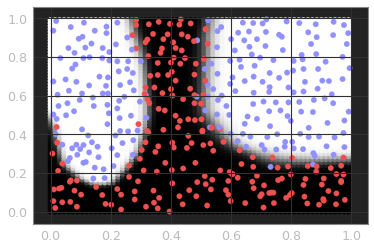

In [13]:
#格子点サンプルの用意と判別結果の取得
xx, yy = np.meshgrid(np.arange(0,1.0,0.015), np.arange(0,1.0,0.015))
mesh = np.array(np.c_[xx.ravel(), yy.ravel()], np.float32)

y_mesh = F.softmax(model(mesh)).data[:,1]



cm = generate_cmap(["#000000", "#FFFFFF"])

plt.scatter(mesh[:,0], mesh[:,1], c=y_mesh, cmap=cm)

plotWholeData()

ログに記録したtest/trainでのloss/accuracyからグラフを作成した

lossはエポック数を重ねると、わずかではあるがtrainに対しては改善、testに対しては悪化している様子が見て取れる


<img src="first_loss.png" width=400px>
<img src="first_accuracy.png" width=400px>